# **Backtesting an RSI Trading Strategy**

This notebook implements and evaluates a simple momentum trading strategy based on the **Relative Strength Index (RSI)**.

### **Strategy Logic:**

The strategy is based on the concept of mean reversion:

* **Buy Signal:** When the RSI crosses *below* the oversold threshold (e.g., 30), we enter a long position.  
* **Sell Signal:** When the RSI crosses *above* the overbought threshold (e.g., 70), we exit the position (go flat).

### **Project Workflow:**

1. **Setup:** Import necessary libraries (yfinance, pandas, pandas\_ta, matplotlib) and define key parameters (ticker, dates, RSI settings).  
2. **Data Retrieval:** Fetch historical stock data using yfinance.  
3. **Indicator Calculation:** Compute the RSI using the pandas\_ta library.  
4. **Backtesting:**  
   * Generate buy (1) and sell (-1) signals based on RSI thresholds.  
   * Create a position column (1 for long, 0 for flat) based on these signals.  
   * Calculate daily strategy returns based on the previous day's position.  
   * Calculate cumulative returns for both the strategy and a simple "Buy and Hold" approach.  
5. **Visualization:** Plot the results in three parts:  
   * Stock price with buy/sell signal markers.  
   * The RSI indicator with its oversold/overbought thresholds.  
   * A comparison of the cumulative returns (Strategy vs. Buy & Hold).

### Import Modules and some helper functions

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [70]:
def fetch_data(tickers, start, end):
    print(f"Fetching data from {start} to {end}...")
    data = yf.download(tickers, start=start, end=end, back_adjust=True)
    if data.empty:
        raise ValueError(f"No data retrieved")
    print("Data fetched successfully.")
    return data['Close'].dropna(axis=1, how='any')

def calculate_rsi(df, window):
    data = df.copy()
    # Calculate price change
    delta = data['Close'].diff(1)
    
    # Separate gains (up) and losses (down)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate Exponential Moving Average (EMA) of gains and losses
    avg_gain = gain.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window - 1, min_periods=window).mean()
    
    # Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss
    
    # Calculate RSI
    data['RSI'] = 100 - (100 / (1 + rs))
    return data

def backtest_rsi_strategy(df, oversold, overbought, init_invest=10000):
    """
    Identifies oversold/overbought points and backtests performance.
    Strategy: Buy when RSI crosses below oversold (30). Sell when RSI crosses above overbought (70).
    """
    # 1. Generate Buy/Sell Signals
    data = df.copy()
    # A 'signal' column: 1 for Buy, -1 for Sell, 0 for Hold
    data['Signal'] = 0.0
    
    # Flag to track current position (0: no position, 1: long position)
    position = 0
    
    for i in range(1, len(data)):
        # Buy condition: RSI crosses below oversold threshold
        if data['RSI'].iloc[i] < oversold and data['RSI'].iloc[i-1] >= oversold and position == 0:
            data.loc[data.index[i], 'Signal'] = 1  # Buy
            position = 1
        
        # Sell condition: RSI crosses above overbought threshold
        elif data['RSI'].iloc[i] > overbought and data['RSI'].iloc[i-1] <= overbought and position == 1:
            data.loc[data.index[i], 'Signal'] = -1  # Sell
            position = 0


    data = data.dropna() # skip first 14 days no RSI data
    
    # Create benchmark 
    bench_shares = init_invest / data.iloc[0]['Close']
    data['Bench_values'] = (data['Close'] * bench_shares).round(2)
    
    # Remove any stray signals (like a second buy before a sell)
    # Only keep the signal that changes the position
    data['RSI_Cash_value'] = 0.0
    data['RSI_Stock_Shares'] = 0.0
    data['RSI_Stock_value'] = 0.0
    
    # Simulate trading 
    current_cash = init_invest
    current_shares = 0.0
    
    for i, row in data.iterrows():
        if row['Signal'] == 1:
            # buy
            current_shares = current_cash / row['Close']
            data.loc[i ,'RSI_Stock_value'] = current_cash  # All money transitioned to stocks
            current_cash = 0 # Used all cash
            data.loc[i ,'RSI_Stock_Shares'] = current_shares
            data.loc[i ,'RSI_Cash_value'] = 0.0
            
        elif row['Signal'] == -1:
            # sell
            current_cash = current_shares * row['Close'] # All stocks transitioned to money
            current_shares = 0 # All money transitioned to stocks
            
            data.loc[i ,'RSI_Stock_value'] = 0.0  # All money transitioned to stocks
            data.loc[i ,'RSI_Stock_Shares'] = 0.0
            data.loc[i ,'RSI_Cash_value'] = current_cash
            
        else:
            # do nothing
            data.loc[i ,'RSI_Stock_value'] = current_shares * row['Close']
            data.loc[i ,'RSI_Stock_Shares'] = current_shares
            data.loc[i ,'RSI_Cash_value'] = current_cash
            
    data['RSI_Total_value'] = data['RSI_Cash_value'] + data['RSI_Stock_value']

    return data
    
def visualize_results(data, oversold_threshold, overbought_threshold, ticker, rsi_period, start_date, end_date, save_pic=False):
    """
    Visualizes buy/sell points, RSI, and overall returns.
    """
    # --- Part 1: Price and Trade Signals ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    # Top Plot: Price and Signals
    ax1.plot(data.index, data['Close'], label='Close Price', color='lightblue', linewidth=2)
    
    # Filter Buy signals for plotting
    buy_signals = data[data['Signal'] == 1]
    ax1.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', s=100, label='Buy Signal')
    
    # Filter Sell signals for plotting
    sell_signals = data[data['Signal'] == -1]
    ax1.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', s=100, label='Sell Signal')
    
    ax1.set_title(f'{ticker} Price and RSI Trade Signals', fontsize=16)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(loc='upper left')

    # Bottom Plot: RSI Indicator
    ax2.plot(data.index, data['RSI'], label=f'RSI ({rsi_period})', color='purple', linewidth=1.5)
    
    # Draw Overbought/Oversold thresholds
    ax2.axhline(overbought_threshold, linestyle='--', color='red', label='Overbought (70)')
    ax2.axhline(oversold_threshold, linestyle='--', color='green', label='Oversold (30)')
    ax2.axhline(50, linestyle='-', color='gray', alpha=0.5)
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('RSI Value', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper left')
    
    plt.tight_layout()
    if save_pic:
        plt.savefig(f'images/{ticker}_signal.png', dpi=100, bbox_inches='tight')
    plt.show()

    # --- Part 2: Cumulative Returns Comparison ---
    plt.figure(figsize=(14, 6))
    
    # Ensure all returns start at 1.0 for comparison
    data_returns = data
    
    plt.plot(data_returns.index, data_returns['Bench_values'], 
             label=f'{ticker} Benchmark Values (Buy & Hold)', color='blue', linewidth=2)
    
    plt.plot(data_returns.index, data_returns['RSI_Total_value'], 
             label='RSI Strategy Value', color='orange', linewidth=2)
    
    plt.title(f'Cumulative Returns: RSI Strategy vs. Buy & Hold Benchmark for {ticker}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (Base 1.0)', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    if save_pic:
        plt.savefig(f'images/{ticker}_performance.png', dpi=100, bbox_inches='tight')
    plt.show()

    # --- Part 3: Performance Summary ---
    final_benchmark = data['Bench_values'].iloc[-1]
    final_strategy = data['RSI_Total_value'].iloc[-1]

    print("\n--- Backtesting Performance Summary ---")
    print(f"Ticker: {ticker}")
    print(f"Period: {start_date} to {end_date}")
    print(f"RSI Period: {rsi_period}, Buy < {oversold_threshold}, Sell > {overbought_threshold}")
    print(f"Initial Investment Amount: ${data.iloc[0]['Bench_values']:.2f}")
    print(f"Buy & Hold Benchmark: ${final_benchmark:.2f}")
    print(f"RSI Strategy: ${final_strategy:.2f}")
    
    if final_strategy > final_benchmark:
        print("Conclusion: The RSI Strategy OUTPERFORMED the Buy & Hold benchmark.")
    elif final_strategy < final_benchmark:
        print("Conclusion: The RSI Strategy UNDERPERFORMED the Buy & Hold benchmark.")
    else:
        print("Conclusion: The RSI Strategy performed identically to the Buy & Hold benchmark (unlikely).")

## 1. Data Gathering & Cleaning

In [22]:
# Read data
tickers_df = pd.read_csv('data/50_stock_tickers.csv')
TICKERS = tickers_df['Ticker'].unique().tolist()
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

# 1. Fetch Data
all_df = fetch_data(TICKERS, START_DATE, END_DATE)
tickers = all_df.columns.tolist()

/tmp/ipykernel_5676/3880634906.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, back_adjust=True)
[******                12%                       ]  6 of 50 completed

Fetching data from 2020-01-01 to 2024-01-01...


[*********************100%***********************]  50 of 50 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Data fetched successfully.


## 2. Single Stock RSI Evaluation

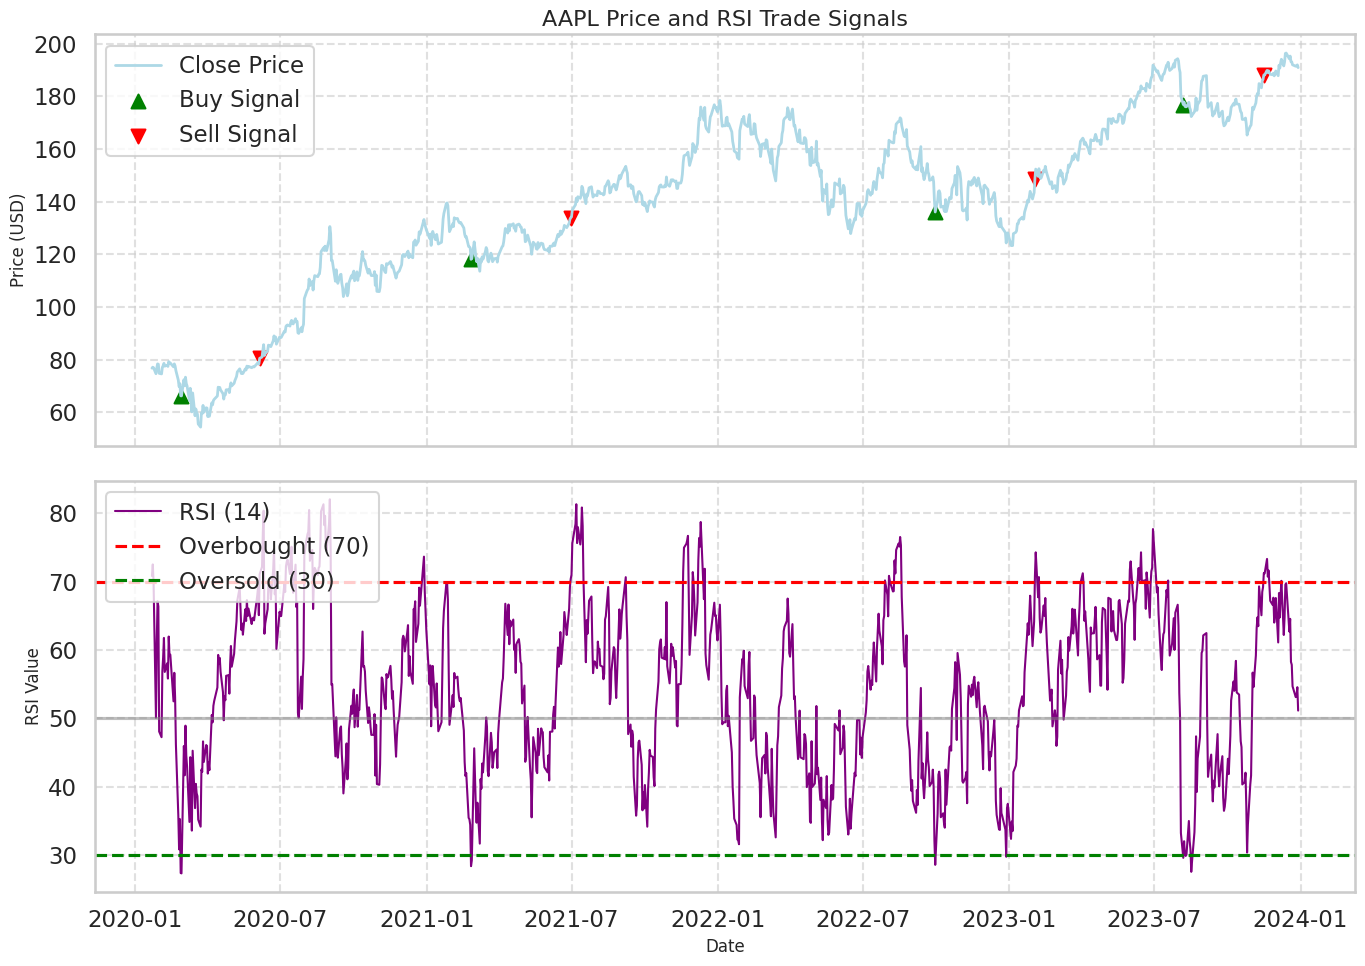

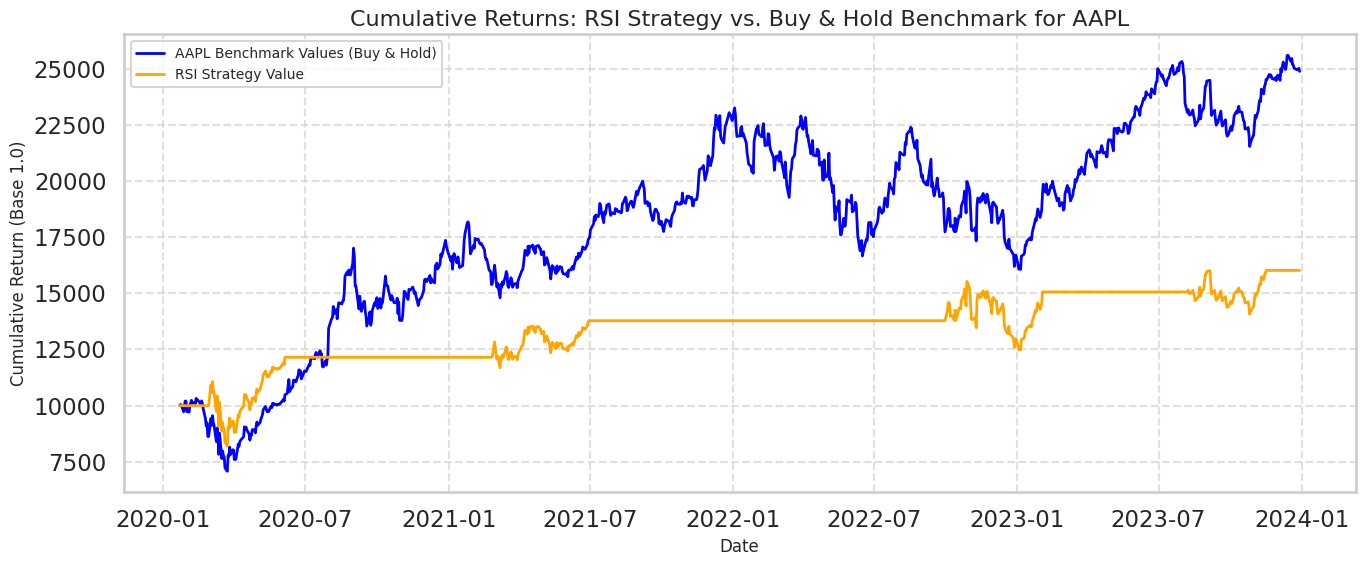


--- Backtesting Performance Summary ---
Ticker: AAPL
Period: 2020-01-01 to 2024-01-01
RSI Period: 14, Buy < 30, Sell > 70
Initial Investment Amount: $10000.00
Buy & Hold Benchmark: $24881.62
RSI Strategy: $16020.63
Conclusion: The RSI Strategy UNDERPERFORMED the Buy & Hold benchmark.


In [71]:
RSI_PERIOD = 14
OVERSOLD_THRESHOLD = 30
OVERBOUGHT_THRESHOLD = 70

ticker = 'AAPL'

# Select single stock
df = all_df[ticker].to_frame()
df['Close'] = df

# Calculate RSI
df = calculate_rsi(df, RSI_PERIOD)

# Backtest Strategy
df = backtest_rsi_strategy(df, OVERSOLD_THRESHOLD, OVERBOUGHT_THRESHOLD)

# 4. Visualize and Summarize
visualize_results(df, OVERSOLD_THRESHOLD, OVERBOUGHT_THRESHOLD, ticker, RSI_PERIOD, START_DATE, END_DATE, True)

## 3. Multiple Stocks RSI Evaluation

In [34]:
# Need to run multiple stocks to get some statistically meaningful reuslt
result_list = []

for tick in tqdm(tickers):
    df = all_df[tick].to_frame()
    df['Close'] = df
    
    # Calculate RSI
    df = calculate_rsi(df, RSI_PERIOD)
    
    # Backtest Strategy
    df = backtest_rsi_strategy(df, OVERSOLD_THRESHOLD, OVERBOUGHT_THRESHOLD)
    result_dict = {
        'Ticker' : tick,
        'RSI_Result' : df.iloc[-1]['RSI_Total_value'],
        'Bench_Result' : df.iloc[-1]['Bench_values']
    }
    result_list.append(result_dict)

result_df = pd.DataFrame(result_list)


  0%|          | 0/49 [00:00<?, ?it/s]

In [44]:
result_df.head(2)

,Ticker,RSI_Result,Bench_Result,Over_Perform
0,AAPL,16020.629975,24881.62,-8860.990025
1,ADBE,13532.610882,17042.79,-3510.179118


Out of 49 tests, 20(40.8%) out perfromed buy-and-hold 
and 29(59.2%) under performed


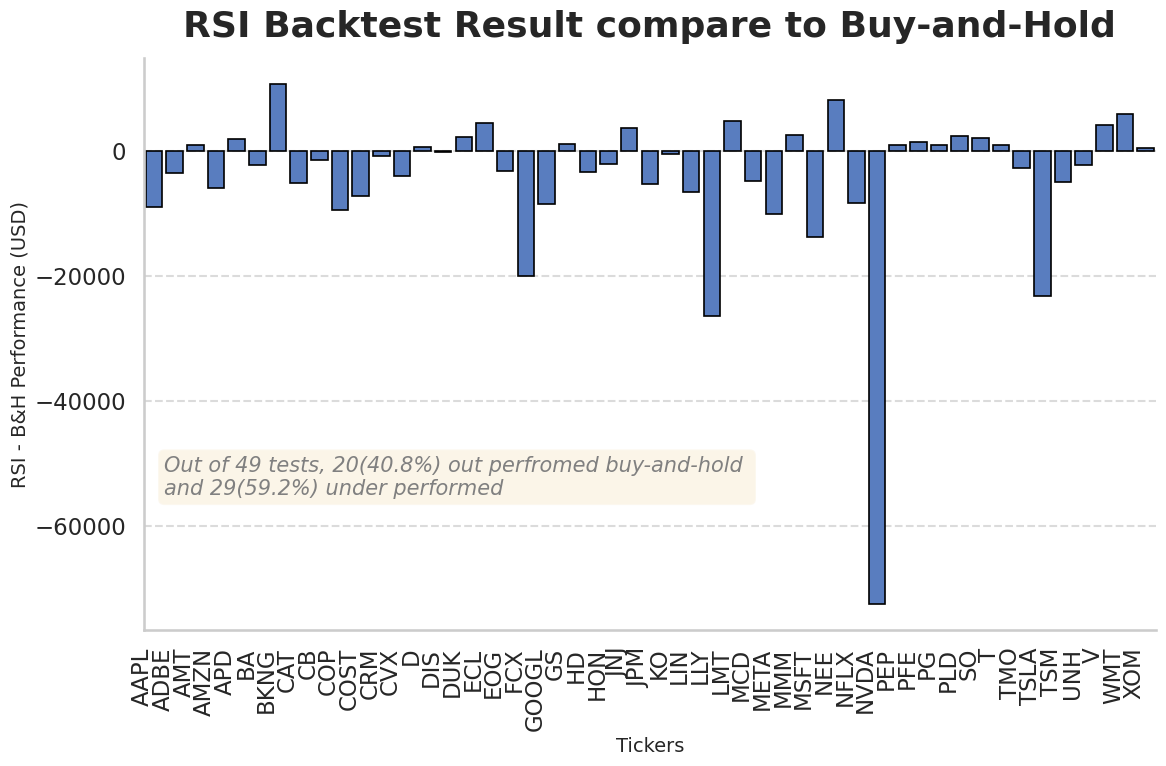

In [69]:
# How many of them 'beat' the buy and hold
result_df['Over_Perform'] = result_df['RSI_Result'] - result_df['Bench_Result']
over_perfom_ct = (result_df['Over_Perform'] > 0 ).sum()
under_perfom_ct = (result_df['Over_Perform'] < 0 ).sum()
total_ct = len(result_df)

 
print(annotate_text :=f"Out of {total_ct} tests, {over_perfom_ct}({100*over_perfom_ct/total_ct :,.1f}%) \
out perfromed buy-and-hold \nand {under_perfom_ct}({100*under_perfom_ct/total_ct :,.1f}%) under performed")
# visual here

# Set Seaborn theme
sns.set_theme(
    style="whitegrid",    # options: darkgrid, whitegrid, dark, white, ticks
    context="talk",       # options: paper, nkotebook, talk, poster
    palette="muted"       # color palette
)

# Create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=result_df,
    x="Ticker",
    y="Over_Perform",
    # palette="coolwarm",    # override theme palette
    edgecolor="black",
    linewidth=1.2
)

# add anotnation here
ax.text(
    0.5, -55000,                     # (x, y) position in figure coordinates (0–1)
    annotate_text, # Text content
    # ha='left', va='bottom',
    fontsize=15, color='gray', style='italic',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3)
)

# Customize labels and title
ax.set_title("RSI Backtest Result compare to Buy-and-Hold", fontsize=26, fontweight='bold', pad=15)
ax.set_xlabel("Tickers", fontsize=14)
ax.set_ylabel("RSI - B&H Performance (USD)", fontsize=14)

# Customize axes and spines
sns.despine(top=True, right=True)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90, ha='right')  # ha='right' aligns the labels neatly
# Show the final plot
plt.savefig('images/RSI-Backtest-Results.png', dpi=100, bbox_inches='tight')
plt.tight_layout()

plt.show()


In [38]:
## result_df.head(2)

np.int64(29)

## 4. Adjust RSI window see if the number changes at all